In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os
import sys
import shutil
from os.path import join

module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path :
    sys.path.append(module_path)

    
import _ressources.chain as chain
import _ressources.tools as tools
import _ressources.lumenclass as lc
import _ressources.gen_config as gc


from scipy.optimize import curve_fit

main_dir = '/Users/mathieuleverge/git/chain_lumen/_data/pumping/2lumens'


In [4]:
def logscale(decades, points, scale=10) :
    Lscale = []
    for d in decades :
        for p in points :
            Lscale += [p*scale**d]
    return Lscale

def read_eventfile(eventfile) :
    s = open(eventfile, 'r').readlines()
    if '(C)' in s[-1].split() :
        return ('C', int(s[-1].split()[-1]))
    elif '(D)' in s[-1].split() :
        return ('D', int(s[-1].split()[-1]))
    elif '(M)' in s[-1].split() :
        return ('M', int(s[-1].split()[-1]))
    
def read_configfile(config_folder, param) :

    lumens = np.loadtxt(join(config_folder, 'lumens.dat'))
    bridges = np.loadtxt(join(config_folder, 'bridges.dat'))

    if param == 'ca' :
        return lumens[1:-1, -1], bridges[1:-1, -1]
    elif param == 'length' :
        return lumens[1:-1, 2], bridges[1:-1, 3]
    elif param == 'nb_ions' :
        return lumens[1:-1, 3]
    return None

def give_outputs(chi_list, folder, param) :
    out_chi = {}
    for chi in chi_list :
        out_chi[chi] = {}
        L = os.listdir(join(folder, 'chiv' + str(chi)))
        for elem in L :
            #if elem.startswith('run') :
            if elem.startswith('run') :
                eventfile = join(folder, 'chiv' + str(chi), elem, 'events.log')
                config_folder = join(folder, 'chiv' + str(chi), elem, 'config')
                try :
                    out_chi[chi][elem] = [read_configfile(config_folder, param), read_eventfile(eventfile)]
                except :
                    print(chi, elem)
    return out_chi

def plot_diagram(out, param_pos) :
    color_dict = {'M' : ['purple', 's'], 
                  'C' : {1 : ['blue', '*'], 2 : ['red', 'o']}, 
                  'D' : ['green', '^']}
    for chi in out.keys() :
        print(str(chi) + '      ', end='\r')
        for sim in out[chi].keys() :
            y = out[chi][sim][0][param_pos[0]][param_pos[1]]
            try :
                fate, winner = out[chi][sim][1]
            except :
                print(chi, sim, out[chi][sim][1])     
                fate = None
            
            if fate == 'C' :
                color, symbol = color_dict[fate][winner]
            elif fate != None :
                color, symbol = color_dict[fate]
            
            if out[chi][sim][1] != None and fate != None :
                plt.scatter(float(chi), y, color = color, marker=symbol)
            else :
                plt.scatter(float(chi), y, color = 'k', marker='*')
            
            
def write_paramfile(param_values, foldername) :
    ca_array = np.zeros((len(param_values), 3))
    for i in range(len(param_values)) :
        ca_array[i] = np.array([[param_values[i], 0., 0.5*param_values[i]]])
    np.savetxt(join(foldername, 'paramsfile.txt'), ca_array, header= ' l1:ca\tl2:ca\tb1:ca', fmt='%.5f')
    
def edit_configtpl(main_dir, subdir, subsubdir, chiv) :
    f = open(join(main_dir, subdir, subsubdir, 'config.conf.tpl'), 'r')
    L = f.readlines()
    f.close()
    L[1] = L[1].replace('chiv1', subsubdir)
    L[38] = L[38].replace('chiv = 1.', 'chiv = ' + chiv)
    s = ''
    for i in range(len(L)) :
        s += str(L[i])
    f = open(join(main_dir, subdir, subsubdir, 'config.conf.tpl'), 'w')
    f.write(s)
    f.close()

In [10]:
new_dict = 0

if new_dict :
    subdir = 'X'
    try : 
        shutil.rmtree(join(main_dir, subdir))
        os.mkdir(join(main_dir, subdir))
    except :
        os.mkdir(join(main_dir, subdir))

    x = np.logspace(-2, 3, 25)
    y = np.logspace(-3, 3, 25)

    cwd = os.getcwd()

    for i in range(len(x)) :
        chiv = "{:.3e}".format(x[i])
        subsubdir = 'chiv'+chiv

        # Make directories
        os.mkdir(join(main_dir, subdir, subsubdir))
        shutil.copy2(join(main_dir, 'config.conf.tpl'), join(main_dir, subdir, subsubdir, 'config.conf.tpl'))
        shutil.copytree(join(main_dir, 'config'), join(main_dir, subdir, subsubdir, 'config'))

        write_paramfile(y, join(main_dir, subdir, subsubdir))

        # Edit config.conf.tpl
        edit_configtpl(main_dir, subdir, subsubdir, chiv)

        # Gen configurations
        os.chdir(join(main_dir, subdir, subsubdir))
        arg1 = 'params=paramsfile.txt'
        gc.main(join(main_dir, subdir, subsubdir, 'config.conf.tpl'), args=['params=paramsfile.txt'])
        os.chdir(cwd)

    s = ''
    for i in range(len(x)) :
        s += "{:.3e}".format(x[i]) + '\n'
    print(s)

1.000e-02
1.616e-02
2.610e-02
4.217e-02
6.813e-02
1.101e-01
1.778e-01
2.873e-01
4.642e-01
7.499e-01
1.212e+00
1.957e+00
3.162e+00
5.109e+00
8.254e+00
1.334e+01
2.154e+01
3.481e+01
5.623e+01
9.085e+01
1.468e+02
2.371e+02
3.831e+02
6.190e+02
1.000e+03



# Fate diagram for $\chi_s = 1$


In [3]:
x = np.logspace(-2, 3, 25)
y = np.logspace(-3, 3, 25)


chis1_list_2 = ["{:.3e}".format(x[i]) for i in range(len(x))]
out_chis1_2 = give_outputs(chis1_list_2, os.path.join(main_dir, 'chis1'), param='ca')


1.616e-02 run0007 None


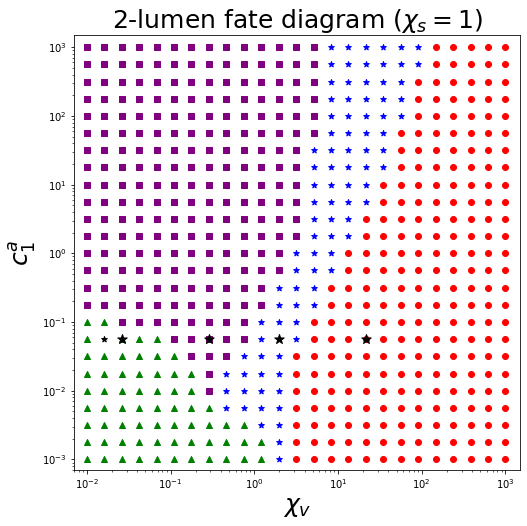

In [7]:
plt.figure(figsize=(8,8))

scale = 'log'

plt.xscale('log')
plt.yscale('log')
plt.xlim(7e-3, 1.5e3)
plt.ylim(7e-4, 1.5e3)
    
plot_diagram(out_chis1_2, param_pos=(0, 0))

#
plt.scatter(2.61015722e-02, 0.05623, marker='*', color='k', s=100)
plt.scatter(0.28729848333536656, 0.05623, marker='*', color='k', s=100) 
plt.scatter(1.9573417814876617, 0.05623, marker='*', color='k', s=100) 
plt.scatter(21.544346, 0.05623, marker='*', color='k', s=100) 


plt.xlabel(r'$\chi_v$', fontsize=25)
plt.ylabel(r'$c^a_1$', fontsize=25)
plt.title(r'2-lumen fate diagram ($\chi_s=1$)', fontsize=25)
plt.savefig('/Users/mathieuleverge/Documents/cavidoc/hydroosmotic/fate_diagram_2lumens_chis1.eps', format='eps')
plt.show()

## Case 1 : 

Import config from /Users/mathieuleverge/git/chain_lumen/_data/pumping/2lumens/chis1/chiv2.610e-02/run0007/config
======= CHAIN =======
Type         : hydroosmotic
Total length : 15.2
Current Time : 0
Screening lengths : 
        xi_s = 3.6666666666666665
        xi_v = 0.09570000000000001
Permeation times :
       tau_s = 1.0
       tau_v = 1.0
Pumping : None
======= LUMENS =======
Nb lumens : 2
Lumen 0 is at position 0.00000 with length 0.00000 and 0.00000 ions with pumping 0.00000
Lumen 1 is at position 6.00000 with length 1.00000 and 1.63783 ions with pumping 0.05623
Lumen 2 is at position 9.10000 with length 1.10000 and 1.98177 ions with pumping 0.00000
Lumen -1 is at position 15.20000 with length 0.00000 and 0.00000 ions with pumping 0.00000
======= BRIDGES ======
Bridge 0 : (0, 1) has length 5.00000 with pumping 0.00000
Bridge 1 : (1, 2) has length 1.00000 with pumping 0.02812
Bridge 2 : (2, -1) has length 5.00000 with pumping 0.00000

Import successful !


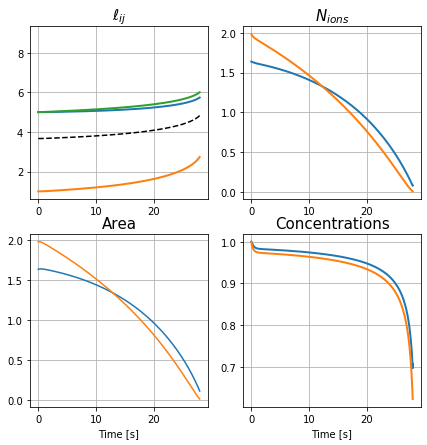

0.05623
('D', 0)






In [7]:
subdir = 'chis1/chiv'+'2.610e-02'+'/run0007'
conf, ch = chain.load_config(os.path.join(main_dir, subdir, 'config.conf'))
print(ch)
x = np.linspace(0., ch.total_length, 1001)
#tools.plot_profile(x, ch)

ell = tools.load_brfile(os.path.join(main_dir, subdir, 'sim_bridges.dat'))

x_log = 0

if ch.lumen_type == 'hydroosmotic' :
    L, nions, pos = tools.load_file(os.path.join(main_dir, subdir, 'sim_all.dat'), hydroosmotic=True)
    tools.plot_evolution(L, nions, ell, x_logscale=x_log, savename=join(main_dir, 'case1.eps'), savefig=True, nbins=5)
else :
    L, pos = tools.load_file(os.path.join(main_dir, subdir, 'sim_all.dat'), hydroosmotic=False)
    tools.plot_evolution_hydraulic(L, ell, x_logscale=x_log)

print(ch.lumens_dict[1].ca)
print(read_eventfile(os.path.join(main_dir, subdir, 'events.log')))
print('\n\n\n')

In [3]:
(1.**2/0.6105653703843762),(1.1**2/0.6105653703843762)

(1.6378262648116755, 1.9817697804221275)

## Case 2 :

Import config from /Users/mathieuleverge/git/chain_lumen/_data/pumping/2lumens/chis1/chiv2.873e-01/run0007/config
======= CHAIN =======
Type         : hydroosmotic
Total length : 15.2
Current Time : 0
Screening lengths : 
        xi_s = 3.6666666666666665
        xi_v = 1.0534333333333332
Permeation times :
       tau_s = 1.0
       tau_v = 1.0
Pumping : None
======= LUMENS =======
Nb lumens : 2
Lumen 0 is at position 0.00000 with length 0.00000 and 0.00000 ions with pumping 0.00000
Lumen 1 is at position 6.00000 with length 1.00000 and 1.63783 ions with pumping 0.05623
Lumen 2 is at position 9.10000 with length 1.10000 and 1.98177 ions with pumping 0.00000
Lumen -1 is at position 15.20000 with length 0.00000 and 0.00000 ions with pumping 0.00000
======= BRIDGES ======
Bridge 0 : (0, 1) has length 5.00000 with pumping 0.00000
Bridge 1 : (1, 2) has length 1.00000 with pumping 0.02812
Bridge 2 : (2, -1) has length 5.00000 with pumping 0.00000

Import successful !


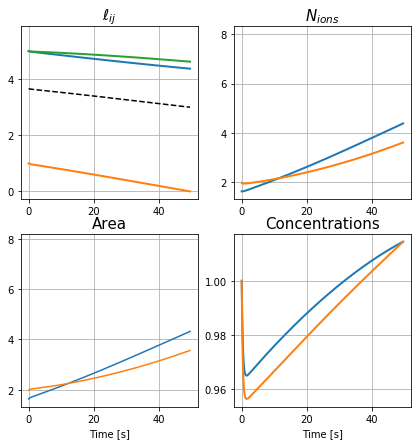

0.05623
('M', 3)






In [8]:
subdir = 'chis1/chiv'+'2.873e-01'+'/run0007'
conf, ch = chain.load_config(os.path.join(main_dir, subdir, 'config.conf'))
print(ch)
x = np.linspace(0., ch.total_length, 1001)
#tools.plot_profile(x, ch)

ell = tools.load_brfile(os.path.join(main_dir, subdir, 'sim_bridges.dat'))

x_log = 0

if ch.lumen_type == 'hydroosmotic' :
    L, nions, pos = tools.load_file(os.path.join(main_dir, subdir, 'sim_all.dat'), hydroosmotic=True)
    tools.plot_evolution(L, nions, ell, x_logscale=x_log, savename=join(main_dir, 'case2.eps'), savefig=True, nbins=5)
else :
    L, pos = tools.load_file(os.path.join(main_dir, subdir, 'sim_all.dat'), hydroosmotic=False)
    tools.plot_evolution_hydraulic(L, ell, x_logscale=x_log)
print(ch.lumens_dict[1].ca)
print(read_eventfile(os.path.join(main_dir, subdir, 'events.log')))
print('\n\n\n')

## Case 3 :

Import config from /Users/mathieuleverge/git/chain_lumen/_data/pumping/2lumens/chis1/chiv1.957e+00/run0007/config
======= CHAIN =======
Type         : hydroosmotic
Total length : 15.2
Current Time : 0
Screening lengths : 
        xi_s = 3.6666666666666665
        xi_v = 7.175666666666666
Permeation times :
       tau_s = 1.0
       tau_v = 1.0
Pumping : None
======= LUMENS =======
Nb lumens : 2
Lumen 0 is at position 0.00000 with length 0.00000 and 0.00000 ions with pumping 0.00000
Lumen 1 is at position 6.00000 with length 1.00000 and 1.63783 ions with pumping 0.05623
Lumen 2 is at position 9.10000 with length 1.10000 and 1.98177 ions with pumping 0.00000
Lumen -1 is at position 15.20000 with length 0.00000 and 0.00000 ions with pumping 0.00000
======= BRIDGES ======
Bridge 0 : (0, 1) has length 5.00000 with pumping 0.00000
Bridge 1 : (1, 2) has length 1.00000 with pumping 0.02812
Bridge 2 : (2, -1) has length 5.00000 with pumping 0.00000

Import successful !


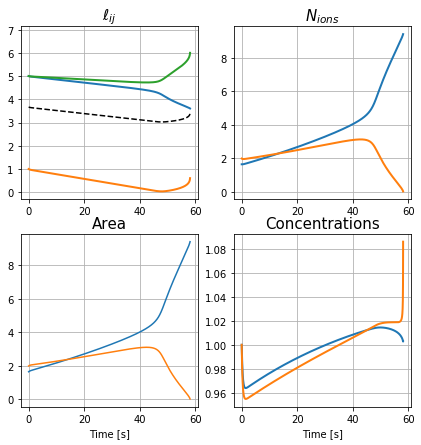

0.05623
('C', 1)






In [24]:
subdir = 'chis1/chiv'+'1.957e+00'+'/run0007'
conf, ch = chain.load_config(os.path.join(main_dir, subdir, 'config.conf'))
print(ch)
x = np.linspace(0., ch.total_length, 1001)
#tools.plot_profile(x, ch)

ell = tools.load_brfile(os.path.join(main_dir, subdir, 'sim_bridges.dat'))

x_log = 0

if ch.lumen_type == 'hydroosmotic' :
    L, nions, pos = tools.load_file(os.path.join(main_dir, subdir, 'sim_all.dat'), hydroosmotic=True)
    tools.plot_evolution(L, nions, ell, x_logscale=x_log, savename=join(main_dir, 'case3.eps'), savefig=True)
else :
    L, pos = tools.load_file(os.path.join(main_dir, subdir, 'sim_all.dat'), hydroosmotic=False)
    tools.plot_evolution_hydraulic(L, ell, x_logscale=x_log)
print(ch.lumens_dict[1].ca)
print(read_eventfile(os.path.join(main_dir, subdir, 'events.log')))
print('\n\n\n')

## Case 4 :

Import config from /Users/mathieuleverge/git/chain_lumen/_data/pumping/2lumens/chis1/chiv2.154e+01/run0007/config
======= CHAIN =======
Type         : hydroosmotic
Total length : 15.2
Current Time : 0
Screening lengths : 
        xi_s = 3.6666666666666665
        xi_v = 78.97999999999999
Permeation times :
       tau_s = 1.0
       tau_v = 1.0
Pumping : None
======= LUMENS =======
Nb lumens : 2
Lumen 0 is at position 0.00000 with length 0.00000 and 0.00000 ions with pumping 0.00000
Lumen 1 is at position 6.00000 with length 1.00000 and 1.63783 ions with pumping 0.05623
Lumen 2 is at position 9.10000 with length 1.10000 and 1.98177 ions with pumping 0.00000
Lumen -1 is at position 15.20000 with length 0.00000 and 0.00000 ions with pumping 0.00000
======= BRIDGES ======
Bridge 0 : (0, 1) has length 5.00000 with pumping 0.00000
Bridge 1 : (1, 2) has length 1.00000 with pumping 0.02812
Bridge 2 : (2, -1) has length 5.00000 with pumping 0.00000

Import successful !


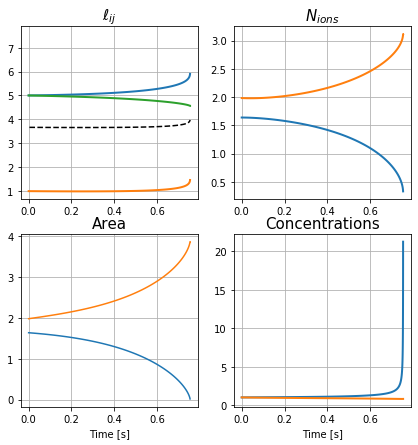

0.05623
('C', 2)






In [23]:
subdir = 'chis1/chiv'+'2.154e+01'+'/run0007'
conf, ch = chain.load_config(os.path.join(main_dir, subdir, 'config.conf'))
print(ch)
x = np.linspace(0., ch.total_length, 1001)
#tools.plot_profile(x, ch)

ell = tools.load_brfile(os.path.join(main_dir, subdir, 'sim_bridges.dat'))

x_log = 0

if ch.lumen_type == 'hydroosmotic' :
    L, nions, pos = tools.load_file(os.path.join(main_dir, subdir, 'sim_all.dat'), hydroosmotic=True)
    tools.plot_evolution(L, nions, ell, x_logscale=x_log, savename=join(main_dir, 'case4.eps'), savefig=True)
else :
    L, pos = tools.load_file(os.path.join(main_dir, subdir, 'sim_all.dat'), hydroosmotic=False)
    tools.plot_evolution_hydraulic(L, ell, x_logscale=x_log)
print(ch.lumens_dict[1].ca)
print(read_eventfile(os.path.join(main_dir, subdir, 'events.log')))
print('\n\n\n')

# More refined fate diagram for $\chi_s = 1$

In [7]:
x = np.logspace(-2, 3, 41)
y = np.logspace(-3, 3, 51)

chis1_list = ["{:.3e}".format(x[i]) for i in range(len(x))]
out_chis1 = give_outputs(chis1_list, os.path.join(main_dir, 'chis1_refined'), param='ca')



In [8]:
out_chis1['2.371e+00']['run0000'][-1] = ('D', 0)
out_chis1['1.778e+00']['run0001'][-1] = ('D', 0)
out_chis1['1.778e+00']['run0002'][-1] = ('D', 0)



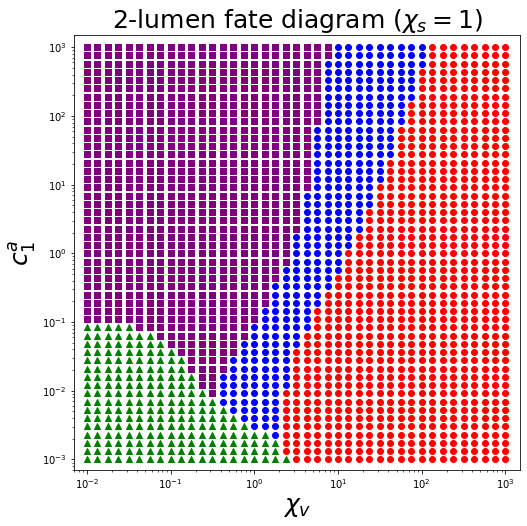

In [9]:
plt.figure(figsize=(8,8))

scale = 'log'

plt.xscale('log')
plt.yscale('log')
plt.xlim(7e-3, 1.5e3)
plt.ylim(7e-4, 1.5e3)
    
plot_diagram(out_chis1, param_pos=(0, 0))
plt.xlabel(r'$\chi_v$', fontsize=25)
plt.ylabel(r'$c^a_1$', fontsize=25)
plt.title(r'2-lumen fate diagram ($\chi_s=1$)', fontsize=25)
#plt.savefig('/Users/mathieuleverge/Documents/cavidoc/hydroosmotic/fate_diagram_2lumens_chis1_refined.eps', format='eps')
plt.show()

In [175]:
subdir = 'chis1/chiv'+'3.162e+00'+'/run0000'
conf, ch = chain.load_config(os.path.join(main_dir, subdir, 'config.conf'))
print(ch)
#x_space = np.linspace(0., ch.total_length, 1001)
#tools.plot_profile(x_space, ch)

ell = tools.load_brfile(os.path.join(main_dir, subdir, 'sim_bridges.dat'))

x_log = 0

if ch.lumen_type == 'hydroosmotic' :
    L, nions, pos = tools.load_file(os.path.join(main_dir, subdir, 'sim_all.dat'), hydroosmotic=True)
    tools.plot_evolution(L, nions, ell, x_logscale=x_log)
else :
    L, pos = tools.load_file(os.path.join(main_dir, subdir, 'sim_all.dat'), hydroosmotic=False)
    tools.plot_evolution_hydraulic(L, ell, x_logscale=x_log)
print(ch.lumens_dict[1].ca)
print(read_eventfile(os.path.join(main_dir, subdir, 'events.log')))
print('\n\n\n')

Import config from /Users/mathieuleverge/git/chain_lumen/_data/pumping/2lumens/chis1/chiv3.162e+00/run0000/config
======= CHAIN =======
Type         : hydroosmotic
Total length : 15.2
Current Time : 0
Screening lengths : 
        xi_s = 3.6666666666666665
        xi_v = 11.594
Permeation times :
       tau_s = 1.0
       tau_v = 1.0
Pumping : None
======= LUMENS =======
Nb lumens : 2
Lumen 0 is at position 0.00000 with length 0.00000 and 0.00000 ions with pumping 0.00000
Lumen 1 is at position 6.00000 with length 1.00000 and 1.63783 ions with pumping 0.00100
Lumen 2 is at position 9.10000 with length 1.10000 and 1.98177 ions with pumping 0.00000
Lumen -1 is at position 15.20000 with length 0.00000 and 0.00000 ions with pumping 0.00000
======= BRIDGES ======
Bridge 0 : (0, 1) has length 5.00000 with pumping 0.00000
Bridge 1 : (1, 2) has length 1.00000 with pumping 0.00050
Bridge 2 : (2, -1) has length 5.00000 with pumping 0.00000



OSError: /Users/mathieuleverge/git/chain_lumen/_data/pumping/2lumens/chis1/chiv3.162e+00/run0000/sim_bridges.dat not found.

# Fate diagram for $\chi_s = 1$ without merging

In [146]:
x = np.logspace(-2, 3, 25)
y = np.logspace(-3, 3, 25)

chis1_list_nomerge = ["{:.3e}".format(x[i]) for i in range(len(x))][5:]
out_chis1_nomerge = give_outputs(chis1_list_nomerge, os.path.join(main_dir, 'chis1'), param='ca')



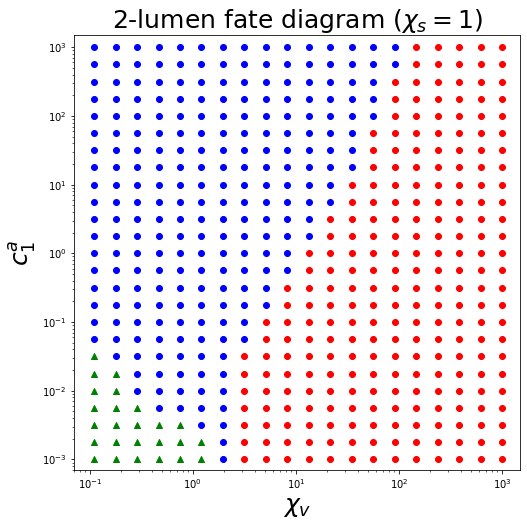

In [147]:
plt.figure(figsize=(8,8))

scale = 'log'

plt.xscale('log')
plt.yscale('log')
plt.xlim(7e-2, 1.5e3)
plt.ylim(7e-4, 1.5e3)
    
plot_diagram(out_chis1_nomerge, param_pos=(0, 0))
plt.xlabel(r'$\chi_v$', fontsize=25)
plt.ylabel(r'$c^a_1$', fontsize=25)
plt.title(r'2-lumen fate diagram ($\chi_s=1$)', fontsize=25)
plt.savefig('/Users/mathieuleverge/Documents/cavidoc/hydroosmotic/fate_diagram_2lumens_chis1_nomerge.eps', format='eps')
plt.show()

Import config from /Users/mathieuleverge/git/chain_lumen/_data/pumping/2lumens/chis1/chiv2.873e-01/run0005/config
Merging not allowed
======= CHAIN =======
Type         : hydroosmotic
Total length : 15.2
Current Time : 0
Screening lengths : 
        xi_s = 3.6666666666666665
        xi_v = 1.0534333333333332
Permeation times :
       tau_s = 1.0
       tau_v = 1.0
Pumping : None
======= LUMENS =======
Nb lumens : 2
Lumen 0 is at position 0.00000 with length 0.00000 and 0.00000 ions with pumping 0.00000
Lumen 1 is at position 6.00000 with length 1.00000 and 1.63783 ions with pumping 0.01778
Lumen 2 is at position 9.10000 with length 1.10000 and 1.98177 ions with pumping 0.00000
Lumen -1 is at position 15.20000 with length 0.00000 and 0.00000 ions with pumping 0.00000
======= BRIDGES ======
Bridge 0 : (0, 1) has length 5.00000 with pumping 0.00000
Bridge 1 : (1, 2) has length 1.00000 with pumping 0.00889
Bridge 2 : (2, -1) has length 5.00000 with pumping 0.00000

Import successful !


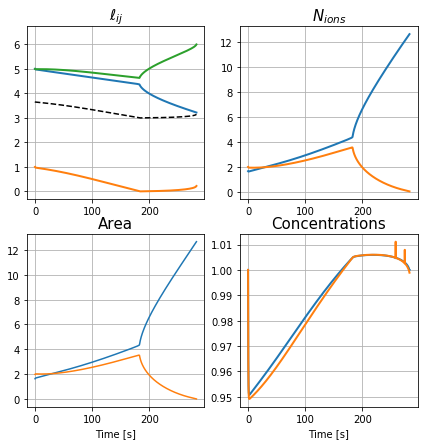

0.01778
('C', 1)






In [141]:
subdir = 'chis1/chiv'+'2.873e-01'+'/run0005'
conf, ch = chain.load_config(os.path.join(main_dir, subdir, 'config.conf'))
print(ch)
#x_space = np.linspace(0., ch.total_length, 1001)
#tools.plot_profile(x_space, ch)

ell = tools.load_brfile(os.path.join(main_dir, subdir, 'sim_bridges.dat'))

x_log = 0

if ch.lumen_type == 'hydroosmotic' :
    L, nions, pos = tools.load_file(os.path.join(main_dir, subdir, 'sim_all.dat'), hydroosmotic=True)
    tools.plot_evolution(L, nions, ell, x_logscale=x_log)
else :
    L, pos = tools.load_file(os.path.join(main_dir, subdir, 'sim_all.dat'), hydroosmotic=False)
    tools.plot_evolution_hydraulic(L, ell, x_logscale=x_log)
print(ch.lumens_dict[1].ca)
print(read_eventfile(os.path.join(main_dir, subdir, 'events.log')))
print('\n\n\n')

In [101]:
x

array([1.00000000e-02, 1.61559810e-02, 2.61015722e-02, 4.21696503e-02,
       6.81292069e-02, 1.10069417e-01, 1.77827941e-01, 2.87298483e-01,
       4.64158883e-01, 7.49894209e-01, 1.21152766e+00, 1.95734178e+00,
       3.16227766e+00, 5.10896977e+00, 8.25404185e+00, 1.33352143e+01,
       2.15443469e+01, 3.48070059e+01, 5.62341325e+01, 9.08517576e+01,
       1.46779927e+02, 2.37137371e+02, 3.83118685e+02, 6.18965819e+02,
       1.00000000e+03])

# Fate diagram for $\chi_s = 10$


In [64]:
x = np.logspace(-2, 3, 25)
y = np.logspace(-3, 3, 25)

chis10_list = ["{:.3e}".format(x[i]) for i in range(len(x))]

out_chis10 = give_outputs(chis10_list, os.path.join(main_dir, 'chis10'), param='ca')


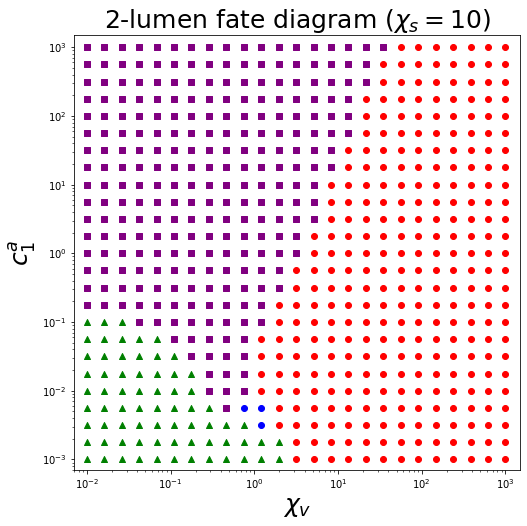

In [65]:
plt.figure(figsize=(8,8))

scale = 'log'

plt.xscale('log')
plt.yscale('log')
plt.xlim(7e-3, 1.5e3)
plt.ylim(7e-4, 1.5e3)
    
plot_diagram(out_chis10, param_pos=(0, 0))
plt.xlabel(r'$\chi_v$', fontsize=25)
plt.ylabel(r'$c^a_1$', fontsize=25)
plt.title(r'2-lumen fate diagram ($\chi_s=10$)', fontsize=25)
plt.savefig('/Users/mathieuleverge/Documents/cavidoc/hydroosmotic/fate_diagram_2lumens_chis10.eps', format='eps')
plt.show()

Import config from /Users/mathieuleverge/git/chain_lumen/_data/pumping/2lumens/chis10/chiv9.085e+01/run0001/config
======= CHAIN =======
Type         : hydroosmotic
Total length : 15.2
Current Time : 0
Screening lengths : 
        xi_s = 36.666666666666664
        xi_v = 333.1166666666666
Permeation times :
       tau_s = 1.0
       tau_v = 1.0
Pumping : None
======= LUMENS =======
Nb lumens : 2
Lumen 0 is at position 0.00000 with length 0.00000 and 0.00000 ions with pumping 0.00000
Lumen 1 is at position 6.00000 with length 1.00000 and 1.63783 ions with pumping 0.00178
Lumen 2 is at position 9.10000 with length 1.10000 and 1.98177 ions with pumping 0.00000
Lumen -1 is at position 15.20000 with length 0.00000 and 0.00000 ions with pumping 0.00000
======= BRIDGES ======
Bridge 0 : (0, 1) has length 5.00000 with pumping 0.00000
Bridge 1 : (1, 2) has length 1.00000 with pumping 0.00089
Bridge 2 : (2, -1) has length 5.00000 with pumping 0.00000

Import successful !


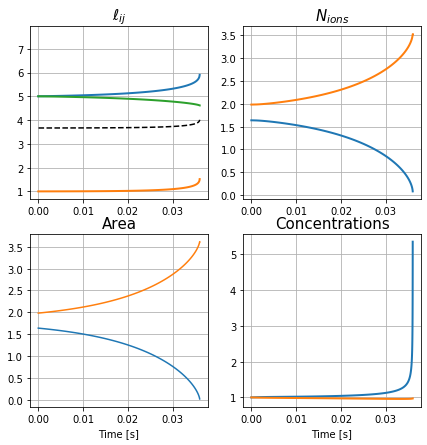

0.00178
('C', 2)






In [112]:
subdir = 'chis10/chiv'+'9.085e+01'+'/run0001'
conf, ch = chain.load_config(os.path.join(main_dir, subdir, 'config.conf'))
print(ch)
x = np.linspace(0., ch.total_length, 1001)
#tools.plot_profile(x, ch)

ell = tools.load_brfile(os.path.join(main_dir, subdir, 'sim_bridges.dat'))

x_log = 0

if ch.lumen_type == 'hydroosmotic' :
    L, nions, pos = tools.load_file(os.path.join(main_dir, subdir, 'sim_all.dat'), hydroosmotic=True)
    tools.plot_evolution(L, nions, ell, x_logscale=x_log)
else :
    L, pos = tools.load_file(os.path.join(main_dir, subdir, 'sim_all.dat'), hydroosmotic=False)
    tools.plot_evolution_hydraulic(L, ell, x_logscale=x_log)
print(ch.lumens_dict[1].ca)
print(read_eventfile(os.path.join(main_dir, subdir, 'events.log')))
print('\n\n\n')

# Fate diagram for $\chi_s = 0.1$

In [91]:
x = np.logspace(-2, 3, 25)
y = np.logspace(-3, 3, 25)

chis01_list = ["{:.3e}".format(x[i]) for i in range(len(x))]
out_chis01 = give_outputs(chis001_list, os.path.join(main_dir, 'chis0.1'), param='ca')



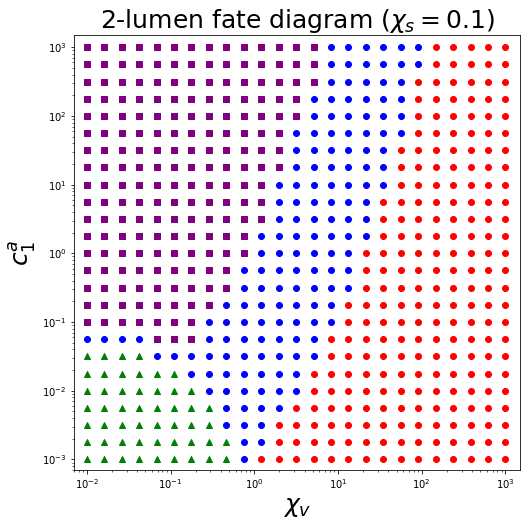

In [92]:
plt.figure(figsize=(8,8))

scale = 'log'

plt.xscale('log')
plt.yscale('log')
plt.xlim(7e-3, 1.5e3)
plt.ylim(7e-4, 1.5e3)
    
plot_diagram(out_chis01, param_pos=(0, 0))
plt.xlabel(r'$\chi_v$', fontsize=25)
plt.ylabel(r'$c^a_1$', fontsize=25)
plt.title(r'2-lumen fate diagram ($\chi_s=0.1$)', fontsize=25)
plt.savefig('/Users/mathieuleverge/Documents/cavidoc/hydroosmotic/fate_diagram_2lumens_chis0.1.eps', format='eps')
plt.show()


Import config from /Users/mathieuleverge/git/chain_lumen/_data/pumping/2lumens/chis0.1/chiv1.000e-02/run0000/config
======= CHAIN =======
Type         : hydroosmotic
Total length : 15.2
Current Time : 0
Screening lengths : 
        xi_s = 0.3666666666666667
        xi_v = 0.03666666666666667
Permeation times :
       tau_s = 1.0
       tau_v = 1.0
Pumping : None
======= LUMENS =======
Nb lumens : 2
Lumen 0 is at position 0.00000 with length 0.00000 and 0.00000 ions with pumping 0.00000
Lumen 1 is at position 6.00000 with length 1.00000 and 1.63783 ions with pumping 0.00100
Lumen 2 is at position 9.10000 with length 1.10000 and 1.98177 ions with pumping 0.00000
Lumen -1 is at position 15.20000 with length 0.00000 and 0.00000 ions with pumping 0.00000
======= BRIDGES ======
Bridge 0 : (0, 1) has length 5.00000 with pumping 0.00000
Bridge 1 : (1, 2) has length 1.00000 with pumping 0.00050
Bridge 2 : (2, -1) has length 5.00000 with pumping 0.00000

Import successful !


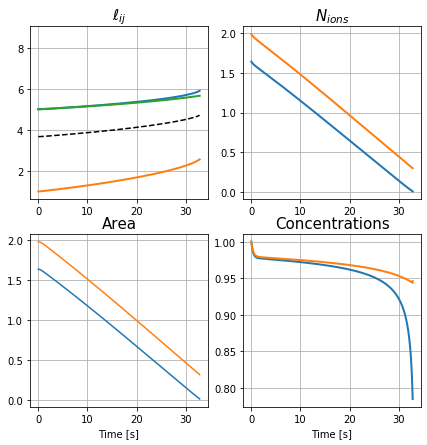

0.001
('D', 0)






In [89]:
subdir = 'chis0.1/chiv'+'1.000e-02'+'/run0000'
conf, ch = chain.load_config(os.path.join(main_dir, subdir, 'config.conf'))
print(ch)
x = np.linspace(0., ch.total_length, 1001)
#tools.plot_profile(x, ch)

ell = tools.load_brfile(os.path.join(main_dir, subdir, 'sim_bridges.dat'))

x_log = 0

if ch.lumen_type == 'hydroosmotic' :
    L, nions, pos = tools.load_file(os.path.join(main_dir, subdir, 'sim_all.dat'), hydroosmotic=True)
    tools.plot_evolution(L, nions, ell, x_logscale=x_log)
else :
    L, pos = tools.load_file(os.path.join(main_dir, subdir, 'sim_all.dat'), hydroosmotic=False)
    tools.plot_evolution_hydraulic(L, ell, x_logscale=x_log)
print(ch.lumens_dict[1].ca)
print(read_eventfile(os.path.join(main_dir, subdir, 'events.log')))
print('\n\n\n')

Import config from /Users/mathieuleverge/git/chain_lumen/_data/pumping/2lumens/chis0.1/chiv1.000e-02/run0000/config
======= CHAIN =======
Type         : hydroosmotic
Total length : 15.2
Current Time : 0
Screening lengths : 
        xi_s = 0.3666666666666667
        xi_v = 0.03666666666666667
Permeation times :
       tau_s = 1.0
       tau_v = 1.0
Pumping : None
======= LUMENS =======
Nb lumens : 2
Lumen 0 is at position 0.00000 with length 0.00000 and 0.00000 ions with pumping 0.00000
Lumen 1 is at position 6.00000 with length 1.00000 and 1.63783 ions with pumping 0.00100
Lumen 2 is at position 9.10000 with length 1.10000 and 1.98177 ions with pumping 0.00000
Lumen -1 is at position 15.20000 with length 0.00000 and 0.00000 ions with pumping 0.00000
======= BRIDGES ======
Bridge 0 : (0, 1) has length 5.00000 with pumping 0.00000
Bridge 1 : (1, 2) has length 1.00000 with pumping 0.00050
Bridge 2 : (2, -1) has length 5.00000 with pumping 0.00000

Import successful !


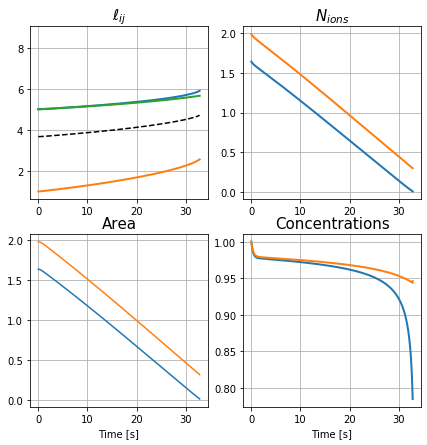

0.001
('D', 0)




Import config from /Users/mathieuleverge/git/chain_lumen/_data/pumping/2lumens/chis0.1/chiv1.000e-02/run0001/config
======= CHAIN =======
Type         : hydroosmotic
Total length : 15.2
Current Time : 0
Screening lengths : 
        xi_s = 0.3666666666666667
        xi_v = 0.03666666666666667
Permeation times :
       tau_s = 1.0
       tau_v = 1.0
Pumping : None
======= LUMENS =======
Nb lumens : 2
Lumen 0 is at position 0.00000 with length 0.00000 and 0.00000 ions with pumping 0.00000
Lumen 1 is at position 6.00000 with length 1.00000 and 1.63783 ions with pumping 0.00178
Lumen 2 is at position 9.10000 with length 1.10000 and 1.98177 ions with pumping 0.00000
Lumen -1 is at position 15.20000 with length 0.00000 and 0.00000 ions with pumping 0.00000
======= BRIDGES ======
Bridge 0 : (0, 1) has length 5.00000 with pumping 0.00000
Bridge 1 : (1, 2) has length 1.00000 with pumping 0.00089
Bridge 2 : (2, -1) has length 5.00000 with pumping 0.00000

Import successful !


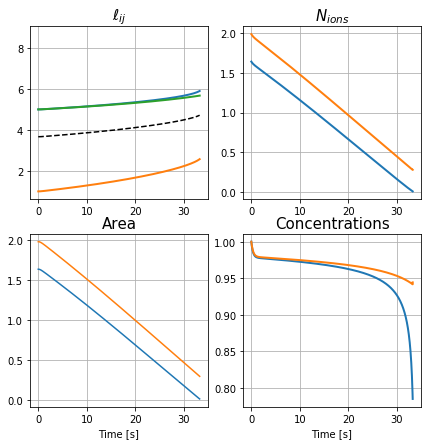

0.00178
('D', 0)




Import config from /Users/mathieuleverge/git/chain_lumen/_data/pumping/2lumens/chis0.1/chiv1.000e-02/run0002/config
======= CHAIN =======
Type         : hydroosmotic
Total length : 15.2
Current Time : 0
Screening lengths : 
        xi_s = 0.3666666666666667
        xi_v = 0.03666666666666667
Permeation times :
       tau_s = 1.0
       tau_v = 1.0
Pumping : None
======= LUMENS =======
Nb lumens : 2
Lumen 0 is at position 0.00000 with length 0.00000 and 0.00000 ions with pumping 0.00000
Lumen 1 is at position 6.00000 with length 1.00000 and 1.63783 ions with pumping 0.00316
Lumen 2 is at position 9.10000 with length 1.10000 and 1.98177 ions with pumping 0.00000
Lumen -1 is at position 15.20000 with length 0.00000 and 0.00000 ions with pumping 0.00000
======= BRIDGES ======
Bridge 0 : (0, 1) has length 5.00000 with pumping 0.00000
Bridge 1 : (1, 2) has length 1.00000 with pumping 0.00158
Bridge 2 : (2, -1) has length 5.00000 with pumping 0.00000

Import successful !


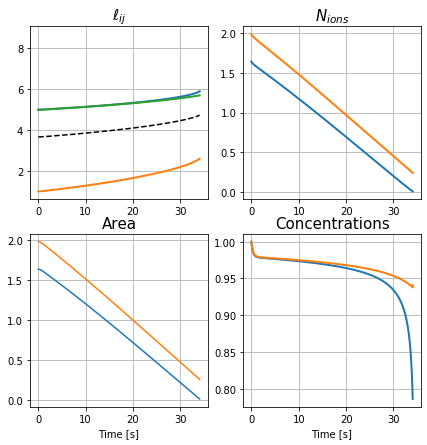

0.00316
('D', 0)




Import config from /Users/mathieuleverge/git/chain_lumen/_data/pumping/2lumens/chis0.1/chiv1.000e-02/run0003/config
======= CHAIN =======
Type         : hydroosmotic
Total length : 15.2
Current Time : 0
Screening lengths : 
        xi_s = 0.3666666666666667
        xi_v = 0.03666666666666667
Permeation times :
       tau_s = 1.0
       tau_v = 1.0
Pumping : None
======= LUMENS =======
Nb lumens : 2
Lumen 0 is at position 0.00000 with length 0.00000 and 0.00000 ions with pumping 0.00000
Lumen 1 is at position 6.00000 with length 1.00000 and 1.63783 ions with pumping 0.00562
Lumen 2 is at position 9.10000 with length 1.10000 and 1.98177 ions with pumping 0.00000
Lumen -1 is at position 15.20000 with length 0.00000 and 0.00000 ions with pumping 0.00000
======= BRIDGES ======
Bridge 0 : (0, 1) has length 5.00000 with pumping 0.00000
Bridge 1 : (1, 2) has length 1.00000 with pumping 0.00281
Bridge 2 : (2, -1) has length 5.00000 with pumping 0.00000

Import successful !


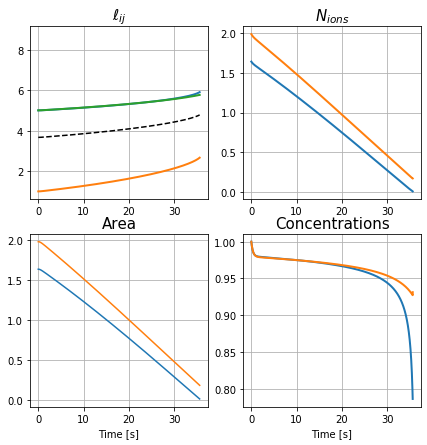

0.00562
('D', 0)




Import config from /Users/mathieuleverge/git/chain_lumen/_data/pumping/2lumens/chis0.1/chiv1.000e-02/run0004/config
======= CHAIN =======
Type         : hydroosmotic
Total length : 15.2
Current Time : 0
Screening lengths : 
        xi_s = 0.3666666666666667
        xi_v = 0.03666666666666667
Permeation times :
       tau_s = 1.0
       tau_v = 1.0
Pumping : None
======= LUMENS =======
Nb lumens : 2
Lumen 0 is at position 0.00000 with length 0.00000 and 0.00000 ions with pumping 0.00000
Lumen 1 is at position 6.00000 with length 1.00000 and 1.63783 ions with pumping 0.01000
Lumen 2 is at position 9.10000 with length 1.10000 and 1.98177 ions with pumping 0.00000
Lumen -1 is at position 15.20000 with length 0.00000 and 0.00000 ions with pumping 0.00000
======= BRIDGES ======
Bridge 0 : (0, 1) has length 5.00000 with pumping 0.00000
Bridge 1 : (1, 2) has length 1.00000 with pumping 0.00500
Bridge 2 : (2, -1) has length 5.00000 with pumping 0.00000

Import successful !


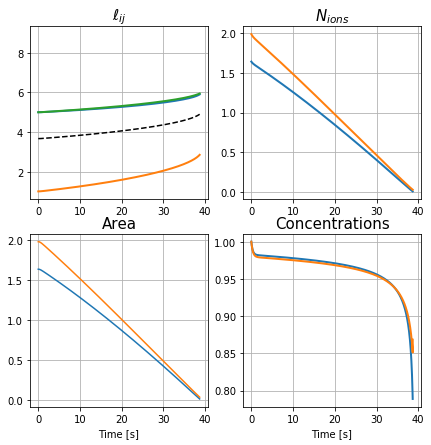

0.01
('D', 0)




Import config from /Users/mathieuleverge/git/chain_lumen/_data/pumping/2lumens/chis0.1/chiv1.000e-02/run0005/config
======= CHAIN =======
Type         : hydroosmotic
Total length : 15.2
Current Time : 0
Screening lengths : 
        xi_s = 0.3666666666666667
        xi_v = 0.03666666666666667
Permeation times :
       tau_s = 1.0
       tau_v = 1.0
Pumping : None
======= LUMENS =======
Nb lumens : 2
Lumen 0 is at position 0.00000 with length 0.00000 and 0.00000 ions with pumping 0.00000
Lumen 1 is at position 6.00000 with length 1.00000 and 1.63783 ions with pumping 0.01778
Lumen 2 is at position 9.10000 with length 1.10000 and 1.98177 ions with pumping 0.00000
Lumen -1 is at position 15.20000 with length 0.00000 and 0.00000 ions with pumping 0.00000
======= BRIDGES ======
Bridge 0 : (0, 1) has length 5.00000 with pumping 0.00000
Bridge 1 : (1, 2) has length 1.00000 with pumping 0.00889
Bridge 2 : (2, -1) has length 5.00000 with pumping 0.00000

Import successful !


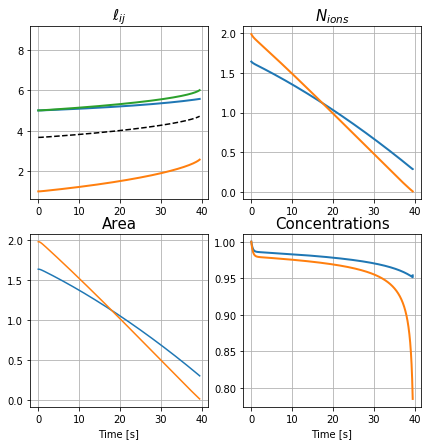

0.01778
('D', 0)




Import config from /Users/mathieuleverge/git/chain_lumen/_data/pumping/2lumens/chis0.1/chiv1.000e-02/run0006/config
======= CHAIN =======
Type         : hydroosmotic
Total length : 15.2
Current Time : 0
Screening lengths : 
        xi_s = 0.3666666666666667
        xi_v = 0.03666666666666667
Permeation times :
       tau_s = 1.0
       tau_v = 1.0
Pumping : None
======= LUMENS =======
Nb lumens : 2
Lumen 0 is at position 0.00000 with length 0.00000 and 0.00000 ions with pumping 0.00000
Lumen 1 is at position 6.00000 with length 1.00000 and 1.63783 ions with pumping 0.03162
Lumen 2 is at position 9.10000 with length 1.10000 and 1.98177 ions with pumping 0.00000
Lumen -1 is at position 15.20000 with length 0.00000 and 0.00000 ions with pumping 0.00000
======= BRIDGES ======
Bridge 0 : (0, 1) has length 5.00000 with pumping 0.00000
Bridge 1 : (1, 2) has length 1.00000 with pumping 0.01581
Bridge 2 : (2, -1) has length 5.00000 with pumping 0.00000

Import successful !


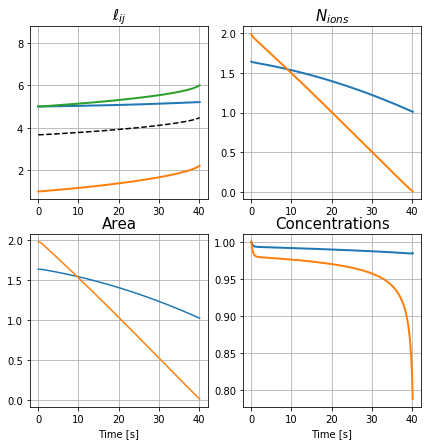

0.03162
('D', 0)




Import config from /Users/mathieuleverge/git/chain_lumen/_data/pumping/2lumens/chis0.1/chiv1.000e-02/run0007/config
======= CHAIN =======
Type         : hydroosmotic
Total length : 15.2
Current Time : 0
Screening lengths : 
        xi_s = 0.3666666666666667
        xi_v = 0.03666666666666667
Permeation times :
       tau_s = 1.0
       tau_v = 1.0
Pumping : None
======= LUMENS =======
Nb lumens : 2
Lumen 0 is at position 0.00000 with length 0.00000 and 0.00000 ions with pumping 0.00000
Lumen 1 is at position 6.00000 with length 1.00000 and 1.63783 ions with pumping 0.05623
Lumen 2 is at position 9.10000 with length 1.10000 and 1.98177 ions with pumping 0.00000
Lumen -1 is at position 15.20000 with length 0.00000 and 0.00000 ions with pumping 0.00000
======= BRIDGES ======
Bridge 0 : (0, 1) has length 5.00000 with pumping 0.00000
Bridge 1 : (1, 2) has length 1.00000 with pumping 0.02812
Bridge 2 : (2, -1) has length 5.00000 with pumping 0.00000

Import successful !


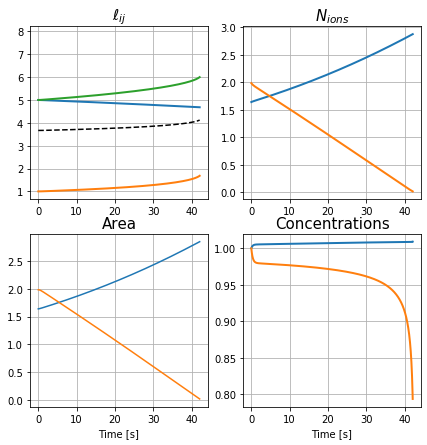

0.05623
('C', 1)




Import config from /Users/mathieuleverge/git/chain_lumen/_data/pumping/2lumens/chis0.1/chiv1.000e-02/run0008/config
======= CHAIN =======
Type         : hydroosmotic
Total length : 15.2
Current Time : 0
Screening lengths : 
        xi_s = 0.3666666666666667
        xi_v = 0.03666666666666667
Permeation times :
       tau_s = 1.0
       tau_v = 1.0
Pumping : None
======= LUMENS =======
Nb lumens : 2
Lumen 0 is at position 0.00000 with length 0.00000 and 0.00000 ions with pumping 0.00000
Lumen 1 is at position 6.00000 with length 1.00000 and 1.63783 ions with pumping 0.10000
Lumen 2 is at position 9.10000 with length 1.10000 and 1.98177 ions with pumping 0.00000
Lumen -1 is at position 15.20000 with length 0.00000 and 0.00000 ions with pumping 0.00000
======= BRIDGES ======
Bridge 0 : (0, 1) has length 5.00000 with pumping 0.00000
Bridge 1 : (1, 2) has length 1.00000 with pumping 0.05000
Bridge 2 : (2, -1) has length 5.00000 with pumping 0.00000

Import successful !


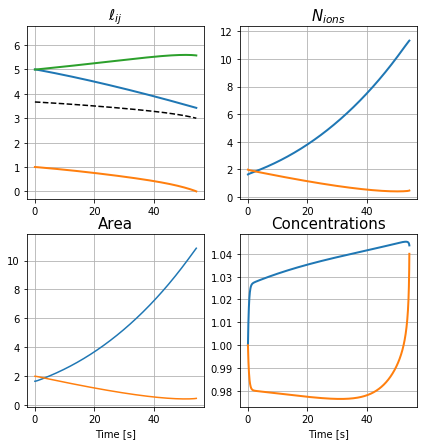

0.1
('M', 3)




Import config from /Users/mathieuleverge/git/chain_lumen/_data/pumping/2lumens/chis0.1/chiv1.000e-02/run0009/config
======= CHAIN =======
Type         : hydroosmotic
Total length : 15.2
Current Time : 0
Screening lengths : 
        xi_s = 0.3666666666666667
        xi_v = 0.03666666666666667
Permeation times :
       tau_s = 1.0
       tau_v = 1.0
Pumping : None
======= LUMENS =======
Nb lumens : 2
Lumen 0 is at position 0.00000 with length 0.00000 and 0.00000 ions with pumping 0.00000
Lumen 1 is at position 6.00000 with length 1.00000 and 1.63783 ions with pumping 0.17783
Lumen 2 is at position 9.10000 with length 1.10000 and 1.98177 ions with pumping 0.00000
Lumen -1 is at position 15.20000 with length 0.00000 and 0.00000 ions with pumping 0.00000
======= BRIDGES ======
Bridge 0 : (0, 1) has length 5.00000 with pumping 0.00000
Bridge 1 : (1, 2) has length 1.00000 with pumping 0.08891
Bridge 2 : (2, -1) has length 5.00000 with pumping 0.00000

Import successful !


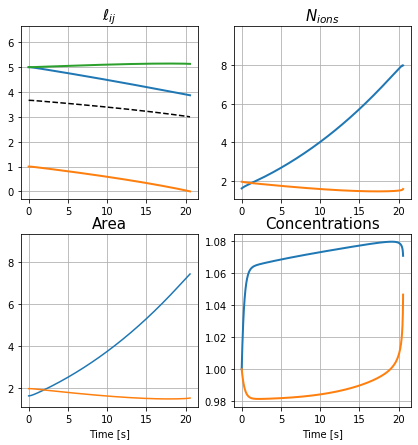

0.17783
('M', 3)




Import config from /Users/mathieuleverge/git/chain_lumen/_data/pumping/2lumens/chis0.1/chiv1.000e-02/run0010/config
======= CHAIN =======
Type         : hydroosmotic
Total length : 15.2
Current Time : 0
Screening lengths : 
        xi_s = 0.3666666666666667
        xi_v = 0.03666666666666667
Permeation times :
       tau_s = 1.0
       tau_v = 1.0
Pumping : None
======= LUMENS =======
Nb lumens : 2
Lumen 0 is at position 0.00000 with length 0.00000 and 0.00000 ions with pumping 0.00000
Lumen 1 is at position 6.00000 with length 1.00000 and 1.63783 ions with pumping 0.31623
Lumen 2 is at position 9.10000 with length 1.10000 and 1.98177 ions with pumping 0.00000
Lumen -1 is at position 15.20000 with length 0.00000 and 0.00000 ions with pumping 0.00000
======= BRIDGES ======
Bridge 0 : (0, 1) has length 5.00000 with pumping 0.00000
Bridge 1 : (1, 2) has length 1.00000 with pumping 0.15811
Bridge 2 : (2, -1) has length 5.00000 with pumping 0.00000

Import successful !


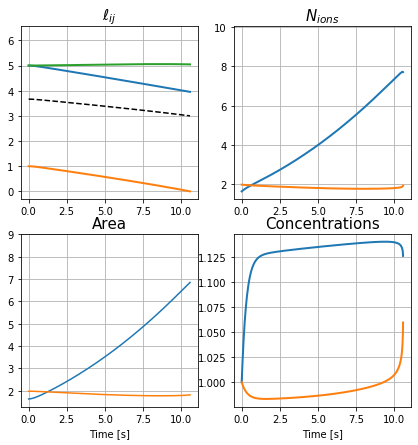

0.31623
('M', 3)




Import config from /Users/mathieuleverge/git/chain_lumen/_data/pumping/2lumens/chis0.1/chiv1.000e-02/run0011/config
======= CHAIN =======
Type         : hydroosmotic
Total length : 15.2
Current Time : 0
Screening lengths : 
        xi_s = 0.3666666666666667
        xi_v = 0.03666666666666667
Permeation times :
       tau_s = 1.0
       tau_v = 1.0
Pumping : None
======= LUMENS =======
Nb lumens : 2
Lumen 0 is at position 0.00000 with length 0.00000 and 0.00000 ions with pumping 0.00000
Lumen 1 is at position 6.00000 with length 1.00000 and 1.63783 ions with pumping 0.56234
Lumen 2 is at position 9.10000 with length 1.10000 and 1.98177 ions with pumping 0.00000
Lumen -1 is at position 15.20000 with length 0.00000 and 0.00000 ions with pumping 0.00000
======= BRIDGES ======
Bridge 0 : (0, 1) has length 5.00000 with pumping 0.00000
Bridge 1 : (1, 2) has length 1.00000 with pumping 0.28117
Bridge 2 : (2, -1) has length 5.00000 with pumping 0.00000

Import successful !


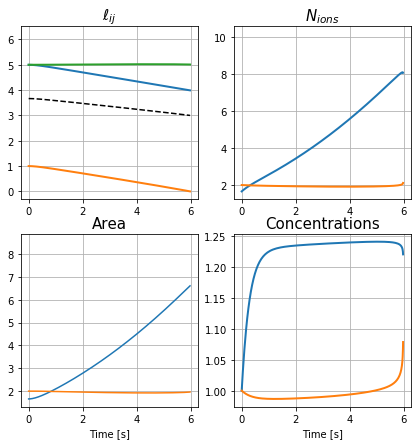

0.56234
('M', 3)




Import config from /Users/mathieuleverge/git/chain_lumen/_data/pumping/2lumens/chis0.1/chiv1.000e-02/run0012/config
======= CHAIN =======
Type         : hydroosmotic
Total length : 15.2
Current Time : 0
Screening lengths : 
        xi_s = 0.3666666666666667
        xi_v = 0.03666666666666667
Permeation times :
       tau_s = 1.0
       tau_v = 1.0
Pumping : None
======= LUMENS =======
Nb lumens : 2
Lumen 0 is at position 0.00000 with length 0.00000 and 0.00000 ions with pumping 0.00000
Lumen 1 is at position 6.00000 with length 1.00000 and 1.63783 ions with pumping 1.00000
Lumen 2 is at position 9.10000 with length 1.10000 and 1.98177 ions with pumping 0.00000
Lumen -1 is at position 15.20000 with length 0.00000 and 0.00000 ions with pumping 0.00000
======= BRIDGES ======
Bridge 0 : (0, 1) has length 5.00000 with pumping 0.00000
Bridge 1 : (1, 2) has length 1.00000 with pumping 0.50000
Bridge 2 : (2, -1) has length 5.00000 with pumping 0.00000

Import successful !


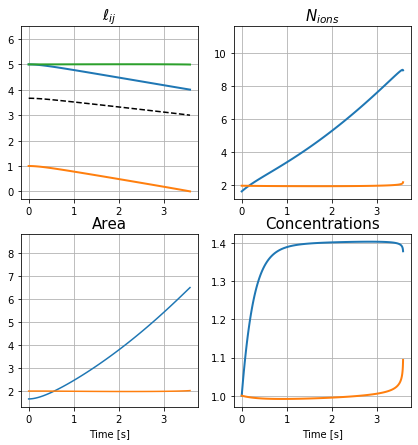

1.0
('M', 3)




Import config from /Users/mathieuleverge/git/chain_lumen/_data/pumping/2lumens/chis0.1/chiv1.000e-02/run0013/config
======= CHAIN =======
Type         : hydroosmotic
Total length : 15.2
Current Time : 0
Screening lengths : 
        xi_s = 0.3666666666666667
        xi_v = 0.03666666666666667
Permeation times :
       tau_s = 1.0
       tau_v = 1.0
Pumping : None
======= LUMENS =======
Nb lumens : 2
Lumen 0 is at position 0.00000 with length 0.00000 and 0.00000 ions with pumping 0.00000
Lumen 1 is at position 6.00000 with length 1.00000 and 1.63783 ions with pumping 1.77828
Lumen 2 is at position 9.10000 with length 1.10000 and 1.98177 ions with pumping 0.00000
Lumen -1 is at position 15.20000 with length 0.00000 and 0.00000 ions with pumping 0.00000
======= BRIDGES ======
Bridge 0 : (0, 1) has length 5.00000 with pumping 0.00000
Bridge 1 : (1, 2) has length 1.00000 with pumping 0.88914
Bridge 2 : (2, -1) has length 5.00000 with pumping 0.00000

Import successful !


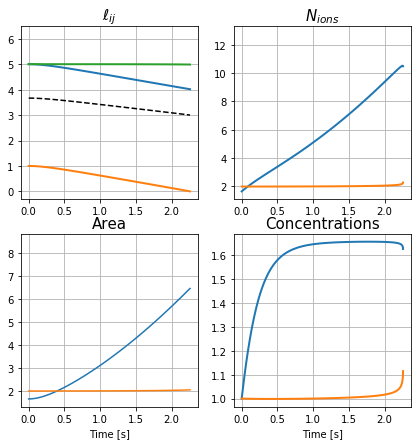

1.77828
('M', 3)




Import config from /Users/mathieuleverge/git/chain_lumen/_data/pumping/2lumens/chis0.1/chiv1.000e-02/run0014/config
======= CHAIN =======
Type         : hydroosmotic
Total length : 15.2
Current Time : 0
Screening lengths : 
        xi_s = 0.3666666666666667
        xi_v = 0.03666666666666667
Permeation times :
       tau_s = 1.0
       tau_v = 1.0
Pumping : None
======= LUMENS =======
Nb lumens : 2
Lumen 0 is at position 0.00000 with length 0.00000 and 0.00000 ions with pumping 0.00000
Lumen 1 is at position 6.00000 with length 1.00000 and 1.63783 ions with pumping 3.16228
Lumen 2 is at position 9.10000 with length 1.10000 and 1.98177 ions with pumping 0.00000
Lumen -1 is at position 15.20000 with length 0.00000 and 0.00000 ions with pumping 0.00000
======= BRIDGES ======
Bridge 0 : (0, 1) has length 5.00000 with pumping 0.00000
Bridge 1 : (1, 2) has length 1.00000 with pumping 1.58114
Bridge 2 : (2, -1) has length 5.00000 with pumping 0.00000

Import successful !


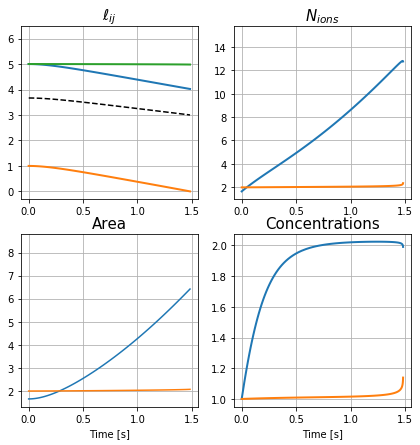

3.16228
('M', 3)




Import config from /Users/mathieuleverge/git/chain_lumen/_data/pumping/2lumens/chis0.1/chiv1.000e-02/run0015/config
======= CHAIN =======
Type         : hydroosmotic
Total length : 15.2
Current Time : 0
Screening lengths : 
        xi_s = 0.3666666666666667
        xi_v = 0.03666666666666667
Permeation times :
       tau_s = 1.0
       tau_v = 1.0
Pumping : None
======= LUMENS =======
Nb lumens : 2
Lumen 0 is at position 0.00000 with length 0.00000 and 0.00000 ions with pumping 0.00000
Lumen 1 is at position 6.00000 with length 1.00000 and 1.63783 ions with pumping 5.62341
Lumen 2 is at position 9.10000 with length 1.10000 and 1.98177 ions with pumping 0.00000
Lumen -1 is at position 15.20000 with length 0.00000 and 0.00000 ions with pumping 0.00000
======= BRIDGES ======
Bridge 0 : (0, 1) has length 5.00000 with pumping 0.00000
Bridge 1 : (1, 2) has length 1.00000 with pumping 2.81171
Bridge 2 : (2, -1) has length 5.00000 with pumping 0.00000

Import successful !


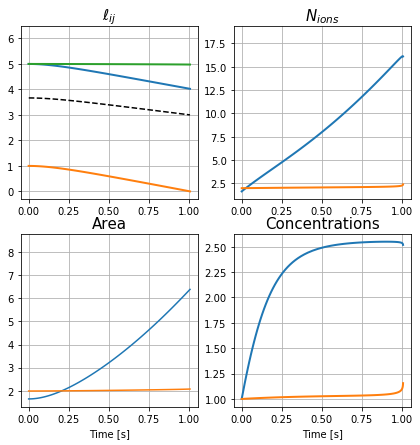

5.62341
('M', 3)




Import config from /Users/mathieuleverge/git/chain_lumen/_data/pumping/2lumens/chis0.1/chiv1.000e-02/run0016/config
======= CHAIN =======
Type         : hydroosmotic
Total length : 15.2
Current Time : 0
Screening lengths : 
        xi_s = 0.3666666666666667
        xi_v = 0.03666666666666667
Permeation times :
       tau_s = 1.0
       tau_v = 1.0
Pumping : None
======= LUMENS =======
Nb lumens : 2
Lumen 0 is at position 0.00000 with length 0.00000 and 0.00000 ions with pumping 0.00000
Lumen 1 is at position 6.00000 with length 1.00000 and 1.63783 ions with pumping 10.00000
Lumen 2 is at position 9.10000 with length 1.10000 and 1.98177 ions with pumping 0.00000
Lumen -1 is at position 15.20000 with length 0.00000 and 0.00000 ions with pumping 0.00000
======= BRIDGES ======
Bridge 0 : (0, 1) has length 5.00000 with pumping 0.00000
Bridge 1 : (1, 2) has length 1.00000 with pumping 5.00000
Bridge 2 : (2, -1) has length 5.00000 with pumping 0.00000

Import successful !

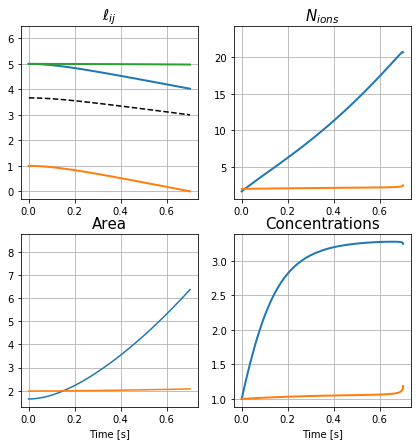

10.0
('M', 3)




Import config from /Users/mathieuleverge/git/chain_lumen/_data/pumping/2lumens/chis0.1/chiv1.000e-02/run0017/config
======= CHAIN =======
Type         : hydroosmotic
Total length : 15.2
Current Time : 0
Screening lengths : 
        xi_s = 0.3666666666666667
        xi_v = 0.03666666666666667
Permeation times :
       tau_s = 1.0
       tau_v = 1.0
Pumping : None
======= LUMENS =======
Nb lumens : 2
Lumen 0 is at position 0.00000 with length 0.00000 and 0.00000 ions with pumping 0.00000
Lumen 1 is at position 6.00000 with length 1.00000 and 1.63783 ions with pumping 17.78279
Lumen 2 is at position 9.10000 with length 1.10000 and 1.98177 ions with pumping 0.00000
Lumen -1 is at position 15.20000 with length 0.00000 and 0.00000 ions with pumping 0.00000
======= BRIDGES ======
Bridge 0 : (0, 1) has length 5.00000 with pumping 0.00000
Bridge 1 : (1, 2) has length 1.00000 with pumping 8.89140
Bridge 2 : (2, -1) has length 5.00000 with pumping 0.00000

Import successful !


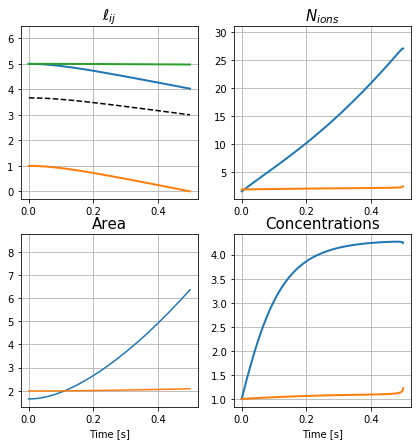

17.78279
('M', 3)




Import config from /Users/mathieuleverge/git/chain_lumen/_data/pumping/2lumens/chis0.1/chiv1.000e-02/run0018/config
======= CHAIN =======
Type         : hydroosmotic
Total length : 15.2
Current Time : 0
Screening lengths : 
        xi_s = 0.3666666666666667
        xi_v = 0.03666666666666667
Permeation times :
       tau_s = 1.0
       tau_v = 1.0
Pumping : None
======= LUMENS =======
Nb lumens : 2
Lumen 0 is at position 0.00000 with length 0.00000 and 0.00000 ions with pumping 0.00000
Lumen 1 is at position 6.00000 with length 1.00000 and 1.63783 ions with pumping 31.62278
Lumen 2 is at position 9.10000 with length 1.10000 and 1.98177 ions with pumping 0.00000
Lumen -1 is at position 15.20000 with length 0.00000 and 0.00000 ions with pumping 0.00000
======= BRIDGES ======
Bridge 0 : (0, 1) has length 5.00000 with pumping 0.00000
Bridge 1 : (1, 2) has length 1.00000 with pumping 15.81139
Bridge 2 : (2, -1) has length 5.00000 with pumping 0.00000

Import successful

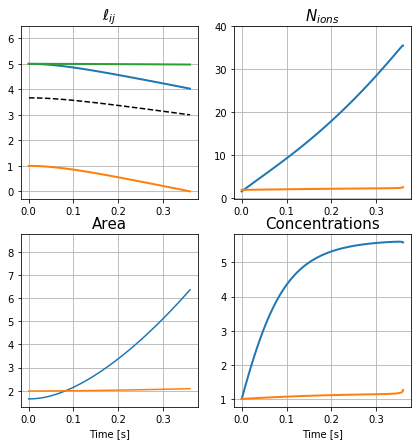

31.62278
('M', 3)




Import config from /Users/mathieuleverge/git/chain_lumen/_data/pumping/2lumens/chis0.1/chiv1.000e-02/run0019/config
======= CHAIN =======
Type         : hydroosmotic
Total length : 15.2
Current Time : 0
Screening lengths : 
        xi_s = 0.3666666666666667
        xi_v = 0.03666666666666667
Permeation times :
       tau_s = 1.0
       tau_v = 1.0
Pumping : None
======= LUMENS =======
Nb lumens : 2
Lumen 0 is at position 0.00000 with length 0.00000 and 0.00000 ions with pumping 0.00000
Lumen 1 is at position 6.00000 with length 1.00000 and 1.63783 ions with pumping 56.23413
Lumen 2 is at position 9.10000 with length 1.10000 and 1.98177 ions with pumping 0.00000
Lumen -1 is at position 15.20000 with length 0.00000 and 0.00000 ions with pumping 0.00000
======= BRIDGES ======
Bridge 0 : (0, 1) has length 5.00000 with pumping 0.00000
Bridge 1 : (1, 2) has length 1.00000 with pumping 28.11707
Bridge 2 : (2, -1) has length 5.00000 with pumping 0.00000

Import successful

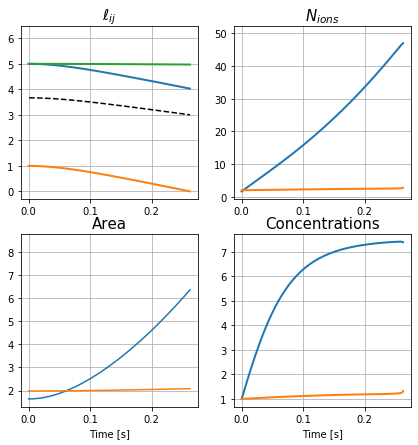

56.23413
('M', 3)




Import config from /Users/mathieuleverge/git/chain_lumen/_data/pumping/2lumens/chis0.1/chiv1.000e-02/run0020/config
======= CHAIN =======
Type         : hydroosmotic
Total length : 15.2
Current Time : 0
Screening lengths : 
        xi_s = 0.3666666666666667
        xi_v = 0.03666666666666667
Permeation times :
       tau_s = 1.0
       tau_v = 1.0
Pumping : None
======= LUMENS =======
Nb lumens : 2
Lumen 0 is at position 0.00000 with length 0.00000 and 0.00000 ions with pumping 0.00000
Lumen 1 is at position 6.00000 with length 1.00000 and 1.63783 ions with pumping 100.00000
Lumen 2 is at position 9.10000 with length 1.10000 and 1.98177 ions with pumping 0.00000
Lumen -1 is at position 15.20000 with length 0.00000 and 0.00000 ions with pumping 0.00000
======= BRIDGES ======
Bridge 0 : (0, 1) has length 5.00000 with pumping 0.00000
Bridge 1 : (1, 2) has length 1.00000 with pumping 50.00000
Bridge 2 : (2, -1) has length 5.00000 with pumping 0.00000

Import successfu

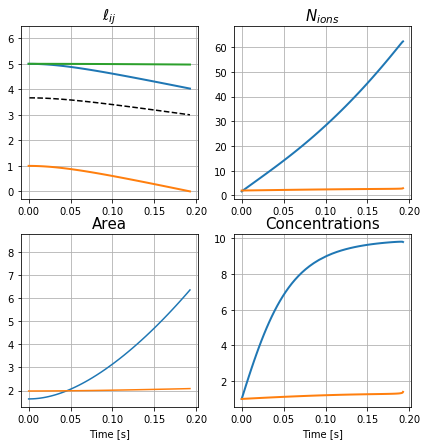

100.0
('M', 3)




Import config from /Users/mathieuleverge/git/chain_lumen/_data/pumping/2lumens/chis0.1/chiv1.000e-02/run0021/config
======= CHAIN =======
Type         : hydroosmotic
Total length : 15.2
Current Time : 0
Screening lengths : 
        xi_s = 0.3666666666666667
        xi_v = 0.03666666666666667
Permeation times :
       tau_s = 1.0
       tau_v = 1.0
Pumping : None
======= LUMENS =======
Nb lumens : 2
Lumen 0 is at position 0.00000 with length 0.00000 and 0.00000 ions with pumping 0.00000
Lumen 1 is at position 6.00000 with length 1.00000 and 1.63783 ions with pumping 177.82794
Lumen 2 is at position 9.10000 with length 1.10000 and 1.98177 ions with pumping 0.00000
Lumen -1 is at position 15.20000 with length 0.00000 and 0.00000 ions with pumping 0.00000
======= BRIDGES ======
Bridge 0 : (0, 1) has length 5.00000 with pumping 0.00000
Bridge 1 : (1, 2) has length 1.00000 with pumping 88.91397
Bridge 2 : (2, -1) has length 5.00000 with pumping 0.00000

Import successful !

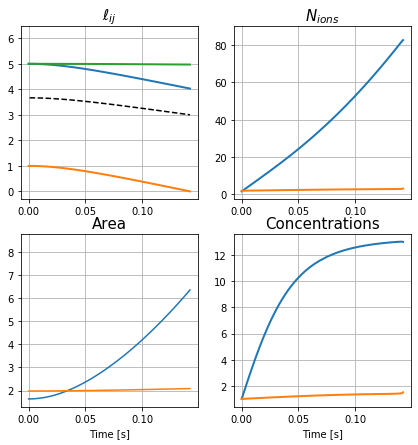

177.82794
('M', 3)




Import config from /Users/mathieuleverge/git/chain_lumen/_data/pumping/2lumens/chis0.1/chiv1.000e-02/run0022/config
======= CHAIN =======
Type         : hydroosmotic
Total length : 15.2
Current Time : 0
Screening lengths : 
        xi_s = 0.3666666666666667
        xi_v = 0.03666666666666667
Permeation times :
       tau_s = 1.0
       tau_v = 1.0
Pumping : None
======= LUMENS =======
Nb lumens : 2
Lumen 0 is at position 0.00000 with length 0.00000 and 0.00000 ions with pumping 0.00000
Lumen 1 is at position 6.00000 with length 1.00000 and 1.63783 ions with pumping 316.22777
Lumen 2 is at position 9.10000 with length 1.10000 and 1.98177 ions with pumping 0.00000
Lumen -1 is at position 15.20000 with length 0.00000 and 0.00000 ions with pumping 0.00000
======= BRIDGES ======
Bridge 0 : (0, 1) has length 5.00000 with pumping 0.00000
Bridge 1 : (1, 2) has length 1.00000 with pumping 158.11388
Bridge 2 : (2, -1) has length 5.00000 with pumping 0.00000

Import success

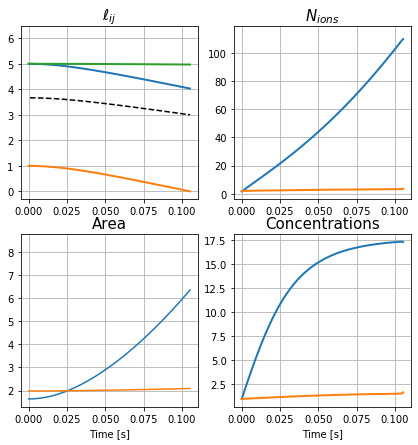

316.22777
('M', 3)




Import config from /Users/mathieuleverge/git/chain_lumen/_data/pumping/2lumens/chis0.1/chiv1.000e-02/run0023/config
======= CHAIN =======
Type         : hydroosmotic
Total length : 15.2
Current Time : 0
Screening lengths : 
        xi_s = 0.3666666666666667
        xi_v = 0.03666666666666667
Permeation times :
       tau_s = 1.0
       tau_v = 1.0
Pumping : None
======= LUMENS =======
Nb lumens : 2
Lumen 0 is at position 0.00000 with length 0.00000 and 0.00000 ions with pumping 0.00000
Lumen 1 is at position 6.00000 with length 1.00000 and 1.63783 ions with pumping 562.34133
Lumen 2 is at position 9.10000 with length 1.10000 and 1.98177 ions with pumping 0.00000
Lumen -1 is at position 15.20000 with length 0.00000 and 0.00000 ions with pumping 0.00000
======= BRIDGES ======
Bridge 0 : (0, 1) has length 5.00000 with pumping 0.00000
Bridge 1 : (1, 2) has length 1.00000 with pumping 281.17066
Bridge 2 : (2, -1) has length 5.00000 with pumping 0.00000

Import success

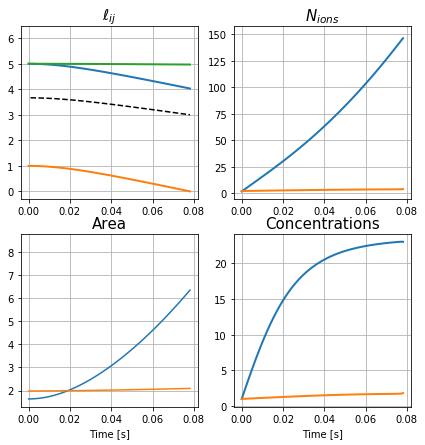

562.34133
('M', 3)




Import config from /Users/mathieuleverge/git/chain_lumen/_data/pumping/2lumens/chis0.1/chiv1.000e-02/run0024/config
======= CHAIN =======
Type         : hydroosmotic
Total length : 15.2
Current Time : 0
Screening lengths : 
        xi_s = 0.3666666666666667
        xi_v = 0.03666666666666667
Permeation times :
       tau_s = 1.0
       tau_v = 1.0
Pumping : None
======= LUMENS =======
Nb lumens : 2
Lumen 0 is at position 0.00000 with length 0.00000 and 0.00000 ions with pumping 0.00000
Lumen 1 is at position 6.00000 with length 1.00000 and 1.63783 ions with pumping 1000.00000
Lumen 2 is at position 9.10000 with length 1.10000 and 1.98177 ions with pumping 0.00000
Lumen -1 is at position 15.20000 with length 0.00000 and 0.00000 ions with pumping 0.00000
======= BRIDGES ======
Bridge 0 : (0, 1) has length 5.00000 with pumping 0.00000
Bridge 1 : (1, 2) has length 1.00000 with pumping 500.00000
Bridge 2 : (2, -1) has length 5.00000 with pumping 0.00000

Import succes

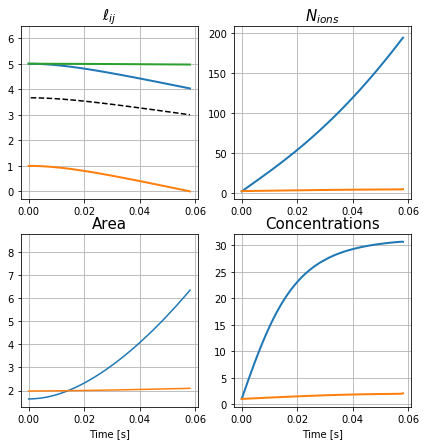

1000.0
('M', 3)






In [90]:
for i in range(25) :
    subdir = 'chis0.1/chiv'+'1.000e-02'+'/run'+str(i).zfill(4)
    conf, ch = chain.load_config(os.path.join(main_dir, subdir, 'config.conf'))
    print(ch)
    x = np.linspace(0., ch.total_length, 1001)
    #tools.plot_profile(x, ch)

    ell = tools.load_brfile(os.path.join(main_dir, subdir, 'sim_bridges.dat'))

    x_log = 0

    if ch.lumen_type == 'hydroosmotic' :
        L, nions, pos = tools.load_file(os.path.join(main_dir, subdir, 'sim_all.dat'), hydroosmotic=True)
        tools.plot_evolution(L, nions, ell, x_logscale=x_log)
    else :
        L, pos = tools.load_file(os.path.join(main_dir, subdir, 'sim_all.dat'), hydroosmotic=False)
        tools.plot_evolution_hydraulic(L, ell, x_logscale=x_log)
    print(ch.lumens_dict[1].ca)
    print(read_eventfile(os.path.join(main_dir, subdir, 'events.log')))
    print('\n\n\n')

# Fate diagram for $\chi_s = 1$ but no fluxes

In [49]:
x = np.logspace(-2, 3, 25)
y = np.logspace(-3, 3, 25)


chis1_list_noflux = ["{:.3e}".format(x[i]) for i in range(len(x))]
out_chis1_noflux = give_outputs(chis1_list_noflux, os.path.join(main_dir, 'chis1_nofluxes'), param='ca')



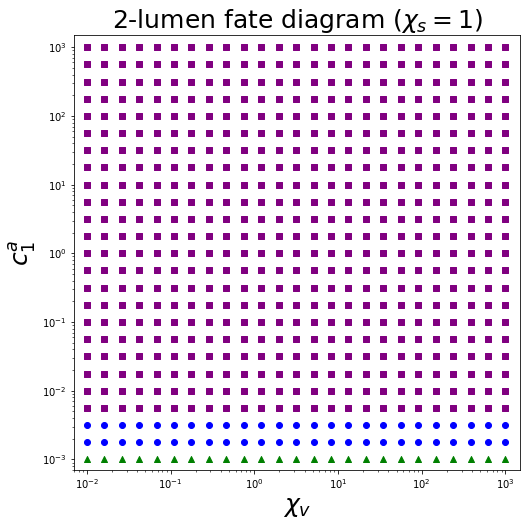

In [50]:
plt.figure(figsize=(8,8))

scale = 'log'

plt.xscale('log')
plt.yscale('log')
plt.xlim(7e-3, 1.5e3)
plt.ylim(7e-4, 1.5e3)
    
plot_diagram(out_chis1_noflux, param_pos=(0, 0))
plt.xlabel(r'$\chi_v$', fontsize=25)
plt.ylabel(r'$c^a_1$', fontsize=25)
plt.title(r'2-lumen fate diagram ($\chi_s=1$)', fontsize=25)
#plt.savefig('/Users/mathieuleverge/Documents/cavidoc/hydroosmotic/fate_diagram_2lumens_chis1_nomerge.eps', format='eps')
plt.show()

Import config from /Users/mathieuleverge/git/chain_lumen/_data/pumping/2lumens/chis1_nofluxes/chiv2.154e+01/run0000/config
======= CHAIN =======
Type         : hydroosmotic
Total length : 15.2
Current Time : 0
Screening lengths : 
        xi_s = 3.6666666666666665
        xi_v = 78.97999999999999
Permeation times :
       tau_s = 1.0
       tau_v = 1.0
Pumping : None
======= LUMENS =======
Nb lumens : 2
Lumen 0 is at position 0.00000 with length 0.00000 and 0.00000 ions with pumping 0.00000
Lumen 1 is at position 6.00000 with length 1.00000 and 1.63783 ions with pumping 0.00100
Lumen 2 is at position 9.10000 with length 1.10000 and 1.98177 ions with pumping 0.00000
Lumen -1 is at position 15.20000 with length 0.00000 and 0.00000 ions with pumping 0.00000
======= BRIDGES ======
Bridge 0 : (0, 1) has length 5.00000 with pumping 0.00000
Bridge 1 : (1, 2) has length 1.00000 with pumping 0.00050
Bridge 2 : (2, -1) has length 5.00000 with pumping 0.00000

Import successful !


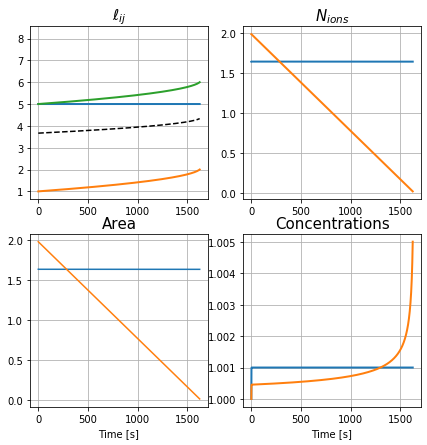

0.001
('D', 0)






In [33]:
for i in range(1) :
    subdir = 'chis1_nofluxes/chiv'+'2.154e+01'+'/run'+str(i).zfill(4)
    conf, ch = chain.load_config(os.path.join(main_dir, subdir, 'config.conf'))
    print(ch)
    x = np.linspace(0., ch.total_length, 1001)
    #tools.plot_profile(x, ch)

    ell = tools.load_brfile(os.path.join(main_dir, subdir, 'sim_bridges.dat'))

    x_log = 0

    if ch.lumen_type == 'hydroosmotic' :
        L, nions, pos = tools.load_file(os.path.join(main_dir, subdir, 'sim_all.dat'), hydroosmotic=True)
        tools.plot_evolution(L, nions, ell, x_logscale=x_log)
    else :
        L, pos = tools.load_file(os.path.join(main_dir, subdir, 'sim_all.dat'), hydroosmotic=False)
        tools.plot_evolution_hydraulic(L, ell, x_logscale=x_log)
    print(ch.lumens_dict[1].ca)
    print(read_eventfile(os.path.join(main_dir, subdir, 'events.log')))
    print('\n\n\n')